学生証番号 :

名前 :

メールアドレス(法政大学) :

# B1-2　Back-propagation neural network (BPNN)を用いた手書き文字認識

$
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\vt}[1]{{\boldsymbol #1}}
$

ここでは、古典的な3層（入力層-中間層（隠れ層）-出力層）のBPNNについて学ぶ。

GoogleのDeep Learning Frameworkである、Tensorflowを便利に使うためのwrapper（[難しいものを]包むもの）であるKerasを用いると驚くほど簡単にneural networkが作れる。

ここではKerasをつかった実装を使って学ぶ。

<img src="https://drive.google.com/uc?export=view&id=1wCzKWbfTLBblSL5c_HyPK9W1J9_yFDJl" width = 50%></img>




## 必要なライブラリのimport

Pythonの数値計算用のライブラリのnumpy, Kerasおよび、グラフ描画のために必要なmatplotlibのライブラリをimportする。

In [1]:
# [1-0]
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## 学習、評価用データの準備
機械学習では、$X$は説明変量、$Y$は、目的変量（予測する値）に用いられることが多い。
$Y$は学習の目的となる値なので「教師データ」と呼ばれ、分類問題では、「教師ラベル」などと呼ばれる。(上の図では、$y$はネットワークの出力で、教師データは$t$と表現されている）

<p>


ここでは、Kerasのrepository(データ置き場）から、MNIST(Modified National Institute of Standards and Technology)と呼ばれる手書き数字のデータセットをダウンロードして、それぞれ x_train, y_train, x_test, y_testに分けて格納している。

MNISTは、手書き数字のデータセットで、0～9の数字が書かれている。
この問題の目的は、$X$で与えられる画像データから、0-9の数字のいずれかを推定する10クラスの分類問題である。

<img src="https://drive.google.com/uc?export=view&id=1thZnba4BJvHB3XtwVXD02ucyt6gR-Ma0" width = 40%></img>




＊_trainは学習用データ、＊_testは性能を測定するためのテスト（評価）用データである。

loadされたデータはpythonの多次元データを扱うnumpy形式の配列である、numpy.ndarrayという形式で保存される。

numpyに対しては、その大きさは **shape**で調べることができる。


In [2]:
# [1-1]
# get_data関数の定義
# flattenは画像データをベクトルに変換するため、data_sizeは学習データの数を絞るために使用
def get_data_mnist(flatten=True, data_size=None):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    # 0 ~ 1の範囲に正規化を行う
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0
    if data_size is not None:
        X_train = X_train[:data_size]
        y_train = y_train[:data_size]
    if flatten:
        X_train = X_train.reshape(len(X_train), -1)
        X_test = X_test.reshape(len(X_test), -1)
    return (X_train, y_train), (X_test, y_test)

In [3]:
# [1-2]
# データのダウンロード（元のデータが自動的に以下の4つに分かれて格納される）
(X_train, y_train), (X_test, y_test) = get_data_mnist(flatten=False)

# ダウンロードしたデータの大きさ（次元数）を確認する。
print(type(X_train))
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# 学習、テスト用データの数をそれぞれ、保存しておく。
num_train = X_train.shape[0]
num_test  = X_test.shape[0]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'numpy.ndarray'>
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


（確認）　ダウンロードしたデータはどんな大きさか？

- データ数はそれぞれいくつか？　　　 -->　（学習用60000、テスト用10000）
- 各データはどんな次元数のデータか？ -->　（$X$は$28 \times 28$, $Y$は$1$)

In [4]:
# [1-3]
# データを表示する関数の作成
# Xにはデータをyにはそれに対応する正解ラベルを渡す
def random_plot(X, y, predict=None):
    W = 10
    H = 5
    fig = plt.figure(figsize=(10, 20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.3, hspace=0.10, wspace=0.10)
    for i in range(5):
        for j in range(10):
            x_tmp = X[y == j]
            idx = np.random.randint(len(x_tmp))
            x = x_tmp[idx].reshape(28, 28)
            ax = fig.add_subplot(H, W, (i * 10) + j + 1, xticks=[], yticks=[])
            ax.imshow(x, cmap="gray")
            if predict is not None:
                pred_tmp = predict[y == j]
                p = pred_tmp[idx]
                ax.set_title(f"{j} -> {p}")
            else:
                ax.set_title(f"label : {j}")

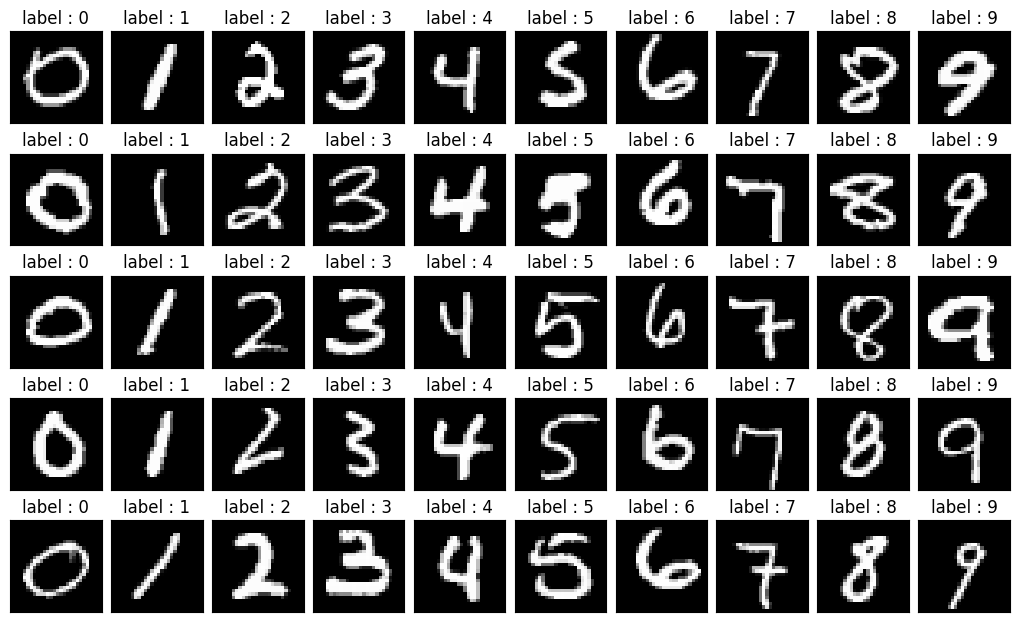

In [5]:
# [1-4]
# 学習用データを覗いてみる。
# 複数回実行すると画像も変化する。
random_plot(X_train, y_train)

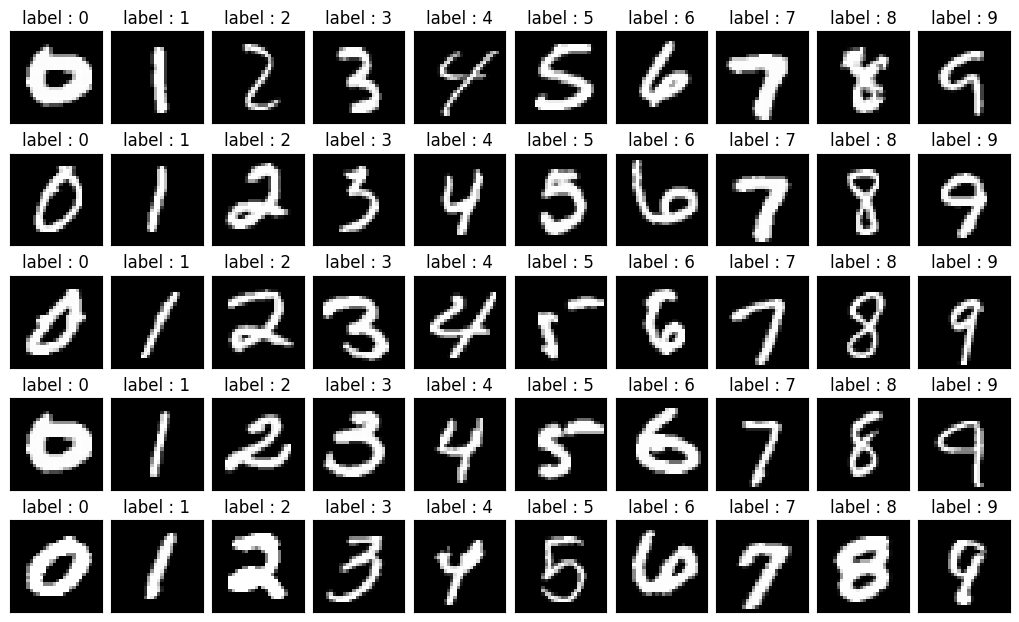

In [6]:
# [1-5]
# テストデータを覗いてみる。
random_plot(X_test, y_test)

---

（重要）
この$X$の各データは2次元画像データであるため、ベクトルの入力のみを受け付けるBPNNには直接入力できない。  

BPNNで画像を認識する場合、画像から色や形、その他いろいろな特徴を数値化して取り出してベクトル化して（例：色、大きさ、形などを数値化したベクトル＝特徴量ベクトル）入力するが、今回は、画像全体をベクトル化（$28\times28$データを1列に並べなおして$784$次元のベクトルに強制的に変形）して用いる。  

（特徴量抽出を行わない今回のやり方は、パターン認識のアプローチとしてはいい方法ではないが、今回は動かすことに重点を置いてあえてこの方法をとる）



In [7]:
# [1-6]
# BPNNに入力するために、各データを1次元化したデータを呼び出す。
(X_train, y_train), (X_test, y_test) = get_data_mnist(
    flatten=True
)  # defaultがTrueなので渡す必要はない
# 一次元にしたデータを確認
print(f"X_train_flat : {X_train.shape}")
print(f"X_test_flat  : {X_test.shape}")

X_train_flat : (60000, 784)
X_test_flat  : (10000, 784)


各画素は8ビットで量子化された値（0-255）で保存されている。  
機械学習において、学習モデルへの入力は大きすぎたり、小さすぎたりすると、学習がうまくすすまないため、一般的に何らかの正規化を行う。  (get_data_mnistの関数内で各値を[0,1]に正規化されている）

## Kerasを用いた最初のBPNNモデル

KerasをつかったBPNNの定義はとても簡単である。  

今回のモデルは、入力が784次元、出力は10次元（認識したいクラスラベル＝数字の種類　と同じ）である。  
中間層（隠れ層）の次元数は、任意に設定できる数であるが、今回は32としている。（変えてもいい）

(input) 784 - 32 - 10 (output)

### 非線形活性化関数

BPNNの中間層は、モデルに非線形性を与える極めて重要なもので、これがない2層のモデル(入力層ー出力層で、重みは1層だけ）だと、得られるモデルは線形分離の問題しか解けない。

歴史的には、ニューロンモデルの活性化関数には**sigmoid関数**が用いられてきたが、

<img src="https://drive.google.com/uc?export=view&id=1TzJnNwDC3Ezml2FKkjVB8jJOfdbDa38j" width = 40%></img>



近年は、中間層ニューロンの活性化関数には **rectified linear unit (ReLU)**を用いれることが多く、今回の実験でもReLUを使っている。

<img src="https://drive.google.com/uc?export=view&id=1DzaeyEmic7F_0i2o5b50GXzyMSf68BrK" width = 40%></img>


ReLUはsigmoidに比べて勾配が大きくとれるメリットがある。負の領域では学習が行えないデメリットがあるが、近年の深いモデルでは、その不自由さが（一部のモデルを除いて）いい意味で制約として働いている。

<br>

### softmax出力

出力層のニューロンには**softmax**を用いている。  

全部のクラス数を$K$としたとき、softmaxは、以下の計算式のように、$k$番目のクラスの最終出力$y_k \quad k=(1,2,\cdots,K)$を以下のように
$$
y_k = \mathsf{softmax}(\vt{a})=\frac{\exp{(a_k)}}{\sum_{j=1}^{K} \exp(a_j)}
$$
求めたものである。

<img src="https://drive.google.com/uc?export=view&id=1aCvKhD1TF7MZlapwrg6bH3akW69T8-ro" width = 40%></img>


ここで$\vt{a}\in \mathbb{R}^K$は、softmax処理が行われる前の出力層の計算結果である。
（＝中間層の出力と中間層ー出力層の重みの積和から閾値を引いたもの）


これにより、各$y_k$は非負、かつこれらの合計が1になるように変換されており、これは確率密度の条件を満たすため、最終出力は**各クラスの確率**とみなすことができる。


softmax処理は、答えが1つの識別問題では日常的に行われる方法である。  




In [16]:
# [1-7]
# Kerasを用いた3層のBPNNモデルの定義
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(784,)),#ここの値が入力に対応するニューロン素子の数。入力サイズが決まっているので変更不可。
        layers.Dense(32, activation="relu"),#ここの値がニューラルネットワークの中間層のニューロンの数。変更可能
        layers.Dense(10, activation="softmax"),#ここの値が出力に対応するニューロン素子の数。10種類の分類をしたいので変更不可。
    ]
)
# 定義したモデルを表示
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

このDenseと書かれているのが、全結合型の重みを保有している層。
全結合層の重みの初期値は小さい乱数を与えることが一般的で、Kerasの場合、特に指定しないと$\pm 0.05$の範囲の一様乱数が用いられて初期化される。  



## 課題B1-2-1 パラメータ数の確認
このモデルの学習パラメータ数が右端(Param #の列)に表れている。なぜこの数になるのか？　根拠を述べよ。

＜ここに回答＞  

-
-

## モデルのコンパイルと学習


### cross-entropy誤差

Kerasで定義したモデルはcompileする必要がある。
上記で定義したBPNNモデルを、compileしている。  

今回、誤差関数には以前用いた2乗和誤差であるMSEではなく、categorial_crossentropyを指定している。

cross-entropyは$\vt{x}\in \mathbb{R}^K$に対する2つの確率分布$p(\vt{x})$, $q(\vt{x})$の違いを定量的に評価する量であり、以下で定義される。  
ここで$N$はデータの個数である。
$$
H(p,q)= -\sum_{n=1}^{N} q(\vt{x}^{(n)})\log p(\vt{x}^{(n)})
$$

この意味は、真の確率分布$q$を確率分布$p$で近似したときに失われる情報量である。
2つの確率分布が完全に一致するとき、cross-entropyは0になり、離れるにつれて大きくなる。

モデルの出力値$\vt{y}$も、教師データ$\vt{t}$の両方が確率密度として記述できる問題を扱う場合（かなり多くの問題が該当する）に誤差関数として利用できる。  

一般的な答えが1種類になるような認識問題の時は、$\vt{t}$をこれまでと同様にその該当する部分だけ1にして残りを0にする $one-hot$表現が用いられる。
この表現は各要素が非負で、合計値が1であるため確率分布とみなる。  
ネットワーク出力$\vt{y}$もsoftmaxを用いることで、各要素が非負、合計値が1になるため、確率分布とみなすことができる。


このcross-entropyを最小化するようにネットワークは学習される。
（2つの確率分布を同じにしたいという目的は理にかなっているうえ、最小2乗誤差よりも、大きく間違った出力の際に誤差やそのgradientが大きくとれ学習が速く進む。ただし適用できるのは目的関数が確率とみなせる問題の時のみ）

そのため、softmax+cross entropyの組み合わせは広く分類問題で用いられる。

<img src="https://drive.google.com/uc?export=view&id=1RgFyHVsR928IWBdKNaLgVUAL3lUb8xeR" width = 40%></img>

今回のモデルで誤差関数として用いられているcategorial cross-entropyは、複数クラスにおけるcross entropyであり、その誤差の値$L_{CE}$は以下のように書ける。

$$
L_{CE}= -\sum_{n=1}^{N}\sum_{k=1}^{K} t_k^{(n)}\log y_k^{(n)}
$$

ここで、真の分布$q$が教師ラベル$\vt{t}$であり、近似している$p$がネットワークのsoftmax出力$\vt{y}$になっていることがわかる。






In [17]:
# [1-8]
# 誤差関数と最適化手法を設定する関数を作成する。
def model_setup(model, optimizer="adam", lr=0.001):
    # optimizerは再急降下法の改良アルゴリズムであり、SGDよりも性能が高い。　（細かい説明は省略）
    if optimizer == "adam":
        optim = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == "sgd":
        optim = keras.optimizers.SGD(learning_rate=lr)
    else:
        raise ValueError
    # sparse_categorical_crossentropy　はcross entropyに対応している。(詳細は省く)
    # 性能評価の基準には"accuracy"（正解率）を用いる。
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
    )

### mean squared error (MSE) とcross entropy error (CE) の比較

以下は、教師シグナルが1の項目に対するMSEとCEの比較を表したグラフである。
出力が理想値から離れるにつれ、CEの方がMSEと比べて急激に誤差が大きくなっていることがわかる。

答えが1の項目に対して、推定値が0.9ならCE=0.105程度、推定値が0.5でCE=0.693程度であるが推定値が0.1だと、CE=2.303になる。  （推定値が0になると、誤差は理論上無限になる）


## 課題B1-2-2 cross-entropy誤差利用時、教師ラベルが0の時に発生する誤差について

教師シグナル$\vt{t}$が0の項については定義上CEは、どんな予測値$\vt{y}$に対しても誤差が0になってしまう。これはなぜ問題にならないのか？　実験が終わった後、レポートを書く際に考察せよ。

（Hint)　cross-entropyを誤差に使えるときは、教師ラベル$\vt{t}$の各次元の合計値が（確率密度とみなすため）必ず1になっていて、他は0の$one-hot$表現になっている。


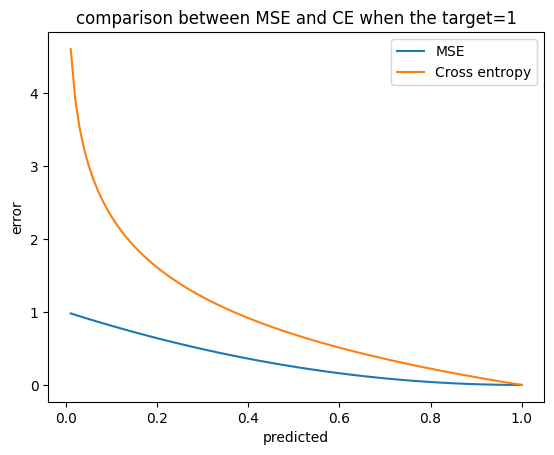

In [18]:
# [1-9]
## 教師ラベルが1になっている出力に対する、モデルの出力と、誤差の関係
# MSEとCross entropy誤差の比較


def MSE(x):
    return (1 - x) * (1 - x)


# CEは教師(q)が1の項目は単に-log(x)になり、
# 教師が0になる項目は全て0になることに注意
def CE(x):
    return -np.log(x)


N = 100
xmin = 0.01
xmax = 1

p = np.linspace(xmin, xmax, N)

plt.plot(p, [MSE(p[k]) for k in range(N)], label="MSE")
plt.plot(p, [CE(p[k]) for k in range(N)], label="Cross entropy")
plt.xlabel("predicted")
plt.ylabel("error")
plt.title("comparison between MSE and CE when the target=1")
plt.legend()
plt.show()

## 学習前のモデルの性能の検証

学習を行う前のBPNNの識別能を求めてみる。（学習前ではうまく識別できない事を確認）

機械学習のほとんどのライブラリでは、定義したモデルに対して様々な関数が用意されていて、便利に実行できる。

evaluate関数は、引数のデータ$X$と答え$Y$を使って、その性能を評価してくれる。



In [19]:
# [1-10]
# モデルのセットアップ
model_setup(model)

# テストデータで評価する
loss_no_train, accuracy_no_train = model.evaluate(X_test, y_test, verbose=0)
print("学習前の誤差 : ", loss_no_train)
print("学習前の正解率 : ", accuracy_no_train)

学習前の誤差 :  2.509613513946533
学習前の正解率 :  0.11249999701976776


## 課題B1-2-3 学習前のBPNNの出力について

学習前のネットワークで得られたcross-entropy誤差から、ネットワークの出力はどんな値だったと推察されるか？

## BPNNモデルの学習

機械学習ライブラリの学習には、ほとんどの場合で　fit()関数を用いる。
下記は学習しながら、その学習ログを保存している。

このKerasで準備されているfit()は便利で、validation_splitで指定した割合のデータをあえて学習に含まず、モデルの性能評価のために用いている。

今回学習データのうち10%をvalidation dataとして用いている。

loss, accuracy　は学習に用いたデータのcross entropy誤差と、平均精度であり、
val_loss, val_accuracyはそれぞれ、学習に用いていないvalidation dataの誤差と平均精度である。

（注）validationデータは、モデルのハイパーパラメータ（構造や学習係数など）を決めるために用いられるデータで、学習データや評価データとは別に準備される。


In [20]:
# [1-11]
# 学習を実行する。
# パラメータの設定
batch_size = 128
epochs = 10
# 　学習回数は上で10回と定義している。
trainlog = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7303 - loss: 0.9827 - val_accuracy: 0.9323 - val_loss: 0.2445
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9231 - loss: 0.2746 - val_accuracy: 0.9522 - val_loss: 0.1923
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9398 - loss: 0.2193 - val_accuracy: 0.9558 - val_loss: 0.1694
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9465 - loss: 0.1898 - val_accuracy: 0.9580 - val_loss: 0.1566
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9527 - loss: 0.1678 - val_accuracy: 0.9630 - val_loss: 0.1407
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9575 - loss: 0.1498 - val_accuracy: 0.9655 - val_loss: 0.1351
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9620 - loss: 0.1374 - val_accuracy: 0.9672 - val_loss: 0.1263
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9642 - loss: 0.1270 - val_accuracy: 0.

## 得られた結果のログから学習曲線を描画する。

学習の特性が確認できる。
Trainingデータと、学習に用いていないValidationデータの差はどういうことを意味するのか？

In [21]:
# [1-12]
# 学習曲線を描画する関数の作成
def plot_result(log):
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(log.history["accuracy"])
    ax1.plot(log.history["val_accuracy"])
    ax1.set_title("Model accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"], loc="best")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(log.history["loss"])
    ax2.plot(log.history["val_loss"])
    ax2.set_title("Model loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"], loc="best")
    plt.show()

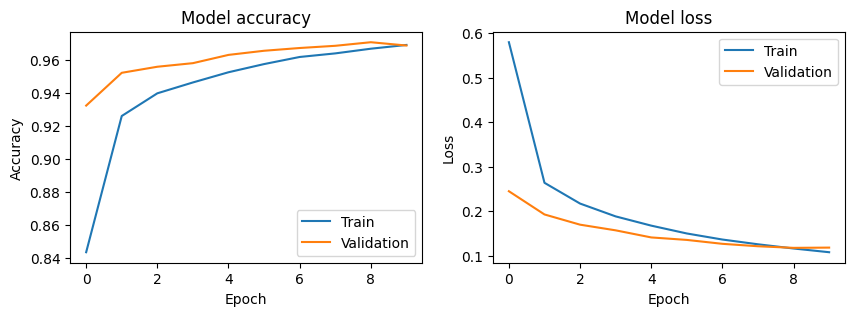

In [22]:
# [1-13]
# 実際に学習曲線の確認
# 右が正解率を左が誤差の推移を表している。
plot_result(trainlog)

## テストデータに対する性能の評価

In [23]:
# [1-14]
# 評価
loss_train, accuracy_train = model.evaluate(X_test, y_test, verbose=0)

# 学習前のスコアの表示
print("学習前の誤差 : ", loss_no_train)
print("学習前の正解率 : ", accuracy_no_train)

# 学習後のスコアの表示
print("===== 学習後 =====")
print(f"学習後の誤差 :  ", loss_train)
print(f"学習後の正解率 : ", accuracy_train)

学習前の誤差 :  2.509613513946533
学習前の正解率 :  0.11249999701976776
===== 学習後 =====
学習後の誤差 :   0.1302472949028015
学習後の正解率 :  0.963100016117096


学習データほどではないが、validation, testデータに対していい識別精度が得られることが確認できる。

次に実際に各データに対する予測や、予測を間違えたデータなどを確認する。予測の確認にはrandom_plot関数を使用する。

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


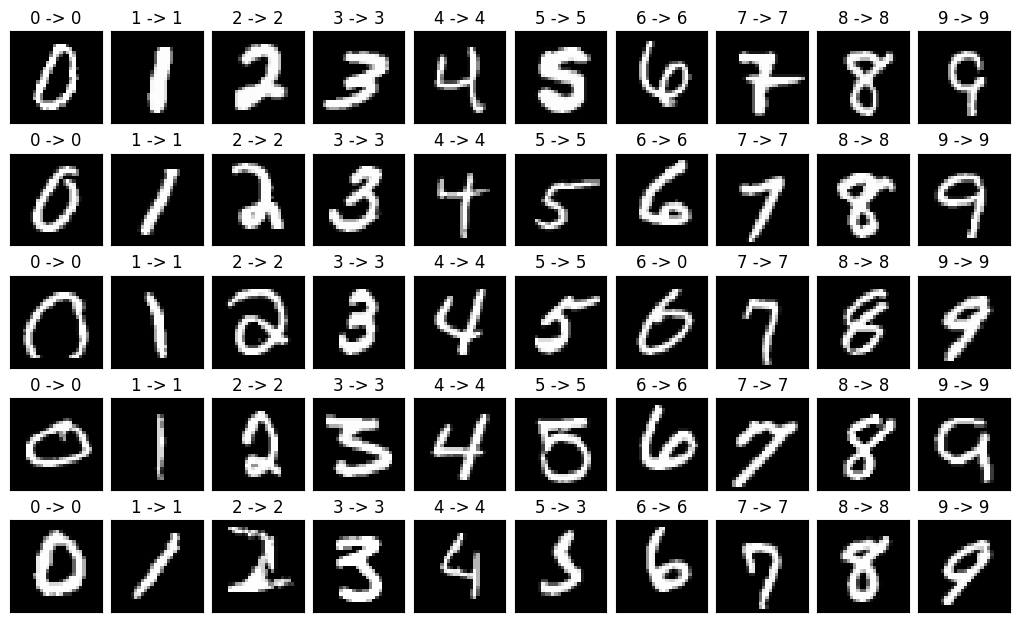

In [24]:
# [1-15]
# それぞれのデータの予測を確認する。
# モデルの予測を取得。
test_predict = np.argmax(model.predict(X_test), 1)
# random_plot関数のpredictに予測を渡す。
random_plot(X_test, y_test, test_predict)
# 実際のラベル -> 予測されたラベル　になっている。

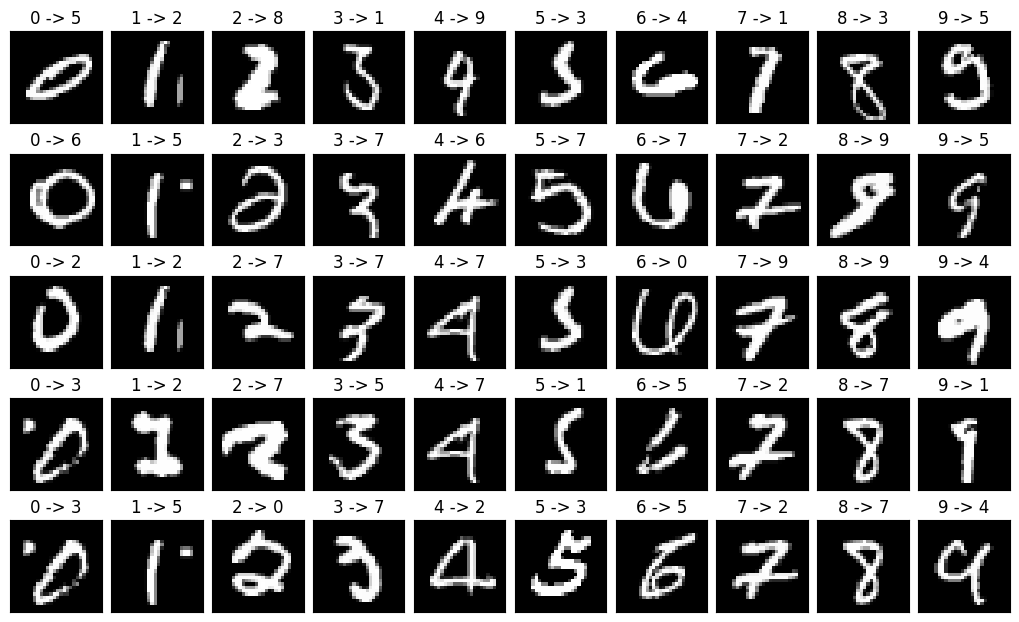

In [25]:
# [1-16]
# 間違えたものに絞って表示
false_idx = y_test != test_predict
# 間違えたもののみを描画
random_plot(X_test[false_idx], y_test[false_idx], test_predict[false_idx])

## 学習データが少ない場合の挙動

今回の例は、問題の難易度に対して学習データが極めて潤沢(6000件x10クラス＝60000件)で、機械学習的には「解きやすい」問題であった。


学習データが合計600件(だいたい各クラス60例のみ）しかない場合に同様のモデルを学習してみる。


In [26]:
# [2-0]
# get_data_mnist関数のdata_sizeの値を変更する。
# テストデータは同じものを使用するので上書きしない
(X_train_small, y_train_small), _ = get_data_mnist(data_size=600)

# データを減らした後の次元数を確認
print("X_train_small : ", X_train_small.shape)
print("y_train_small : ", y_train_small.shape)

X_train_small :  (600, 784)
y_train_small :  (600,)


### 再度モデルの構築

ネットワーク構成自体は前のモデルと全く同じ。

In [28]:
# [2-1]
# 同じ構造でモデルを構築
model_small = keras.Sequential(
    [
        layers.InputLayer(input_shape=(784,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
# 定義したモデルを表示
model_small.summary()

# 前回と同じ条件でsetup
model_setup(model_small)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

### このモデルを600個のデータで学習

今回学習のepochが10回では十分に終わらないので50回にしてみる。

(600個でmini batch sizeが128なので、1回の学習で重みの更新は5回しか起こらないことに注意ー最後のmini batchは128個より小さい）

In [29]:
# [2-2]
# このモデルに600個のデータで学習
epochs = 50
trainlog_small = model_small.fit(
    X_train_small,
    y_train_small,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.1232 - loss: 2.2947 - val_accuracy: 0.2333 - val_loss: 2.1873
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3844 - loss: 2.0401 - val_accuracy: 0.3667 - val_loss: 2.0190
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5434 - loss: 1.8325 - val_accuracy: 0.4333 - val_loss: 1.8470
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5977 - loss: 1.5964 - val_accuracy: 0.4333 - val_loss: 1.6896
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6353 - loss: 1.4189 - val_accuracy: 0.4833 - val_loss: 1.5271
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7076 - loss: 1.2552 - val_accuracy: 0.5667 - val_loss: 1.3809
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7601 - loss: 1.1089 - val_accuracy: 0.6167 - val_loss: 1.2547
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7990 - loss: 0.9735 - val_accuracy: 0.7167 - val_loss: 1.1499

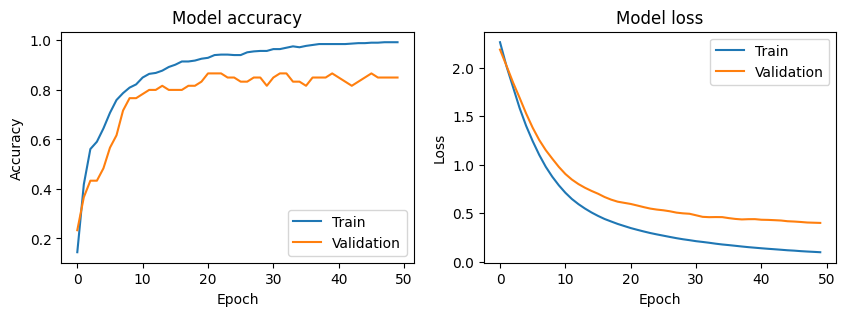

In [30]:
# [2-3]
# データを少なくした場合の学習曲線の描画
plot_result(trainlog_small)

In [31]:
# [2-4]
# testデータに対する性能を確認する
loss_small, accuracy_small = model_small.evaluate(X_test, y_test, verbose=0)

# データを減らす前のスコアの表示
print("データを減らす前の誤差 : ", loss_train)
print("データを減らす前の正解率 : ", accuracy_train)

# データを減らした後のスコアを表示
print("===== データが少ないとき =====")
print(f"データが少ないときの誤差 :  ", loss_small)
print(f"データが少ないときの正解率 : ", accuracy_small)

データを減らす前の誤差 :  0.1302472949028015
データを減らす前の正解率 :  0.963100016117096
===== データが少ないとき =====
データが少ないときの誤差 :   0.4963066875934601
データが少ないときの正解率 :  0.8515999913215637


### 比較してどうだったか？

学習データの数に制限がある場合、  
training（学習用）データに対する精度と、validation（検証用）、テスト用データの精度に差が出始めた。

この差が大きすぎると、モデルが学習データに過度に適合している**過学習**という状態である。
これは問題やモデル（識別器）の複雑さに対して、学習データが十分にある場合に顕著になる。
過学習は、本質的に必要な未知へのデータの適合性（＝汎化性）を失うことになるので、できるけ少なくさせる必要がある。



**過学習を抑制す基本的な方法は以下の3つ**

- 学習データを増やす
- 性能が得られる範囲でモデルの複雑さを減らす（減らしすぎると性能がそもそも得られない）
- モデルの複雑さはそのままに、パラメータが取れる値の範囲に何等かの制約を加えることで、モデルの自由度を減らす（別途説明：精度と過学習抑制を両立する手法として広く用いられる）

である。



In [32]:
# 以下、各自の実験コードは以下のセルを活用して自由に試してみよ。（自由に増やしてよい）


## 課題B1-2-4
以下について、自分なりに条件を考えて、性能を比較し、しっかり考察せよ

- 学習データ数を減らした場合  
- モデルの複雑さ（中間層のニューロンの数）を変えたときの場合
- 学習率を変更させた場合


ヒント :
- データ数を変更する場合は以下のコードを使用（データを上書きしてしまうので嫌なら変数名を変え、学習に渡すときも注意する）
```
data_size = 10000
(X_train, y_train), _ = get_data_mnist(data_size=data_size)
```
- モデル構造や学習率を変更するとき
```
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=784),  # ここは変更しない
        # ここの間を変更する #
        layers.Dense(128, activation="relu"),
        # ここまで #
        layers.Dense(10, activation="softmax"),  # ここは変更しない
    ]
)
# 定義したモデルを確認
model.summary()
# 学習率の変更
lr = 0.001
model_setup(model, lr=lr)
```
- 学習のパラメータ(バッチサイズやエポック数)を変更するとき
```
epochs = 50
batch_size = 128
log = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)
```
- 評価するとき
```
loss, accuracy = model.evaluate(X_test, y_test)
print("誤差　: ", loss)
print("正解率 : ", accuracy)
```

In [33]:
# 以下、各自の実験コードは以下のセルを活用して自由に試してみよ。（自由に増やしてよい）

ここの部分に、試したことと、その結果を以下にまとめる。

 -
 -